In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)


print(proj_root)

d:\Work\repos\RL\phd-rl-algos


In [35]:
import numpy as np
import pandas as pd
import seaborn as sns

from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from dqn.opinion_dynamics.utils.env_setup import build_environment, EnvironmentFactory
from dqn.opinion_dynamics.experiments.baseline import run_policy, run_centrality_policy, flatten_intermediate_states_np

from dynamic_programming.opinion_dynamics.algos import compute_average_error, compute_final_average_error, generate_full_control_policy, generate_control_from_vector
from dynamic_programming.opinion_dynamics.algo_infinite_horizon import value_iteration, extract_policy, create_state_grid
from dynamic_programming.opinion_dynamics.common.viz import plot_opinions_over_time, visualize_policy_from_env, plot_action_heatmap, interpolate_opinion_trajectory



--- Running simulation for validation environment version 0 ---
Policy run terminated after 100 steps. Done=False, Truncated=True


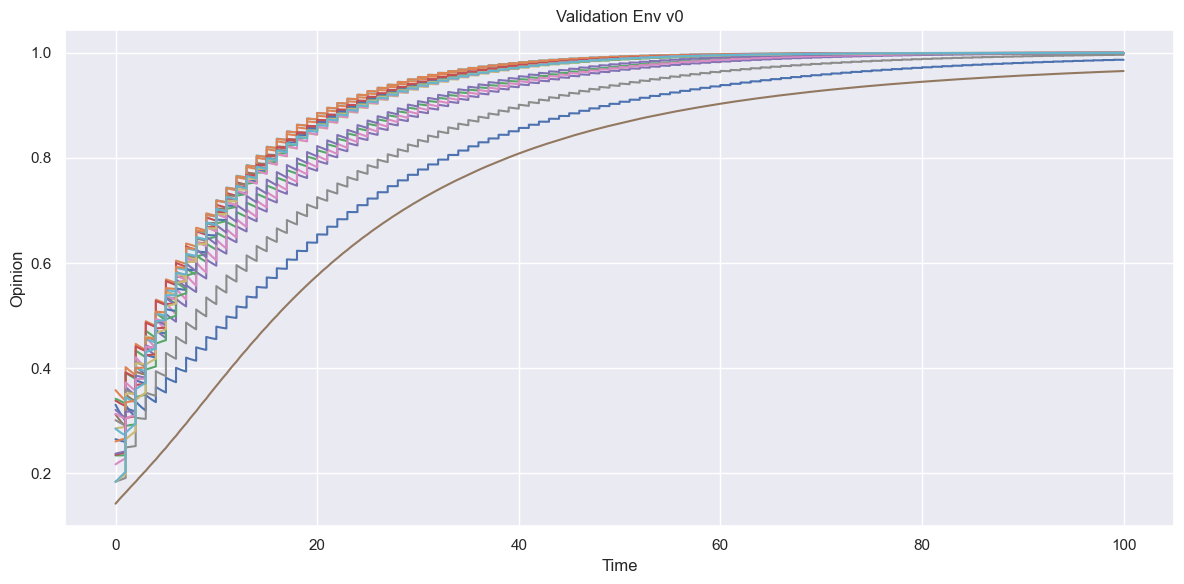

Total discounted reward: -13.2838

--- Running simulation for validation environment version 1 ---
Policy run terminated after 100 steps. Done=False, Truncated=True


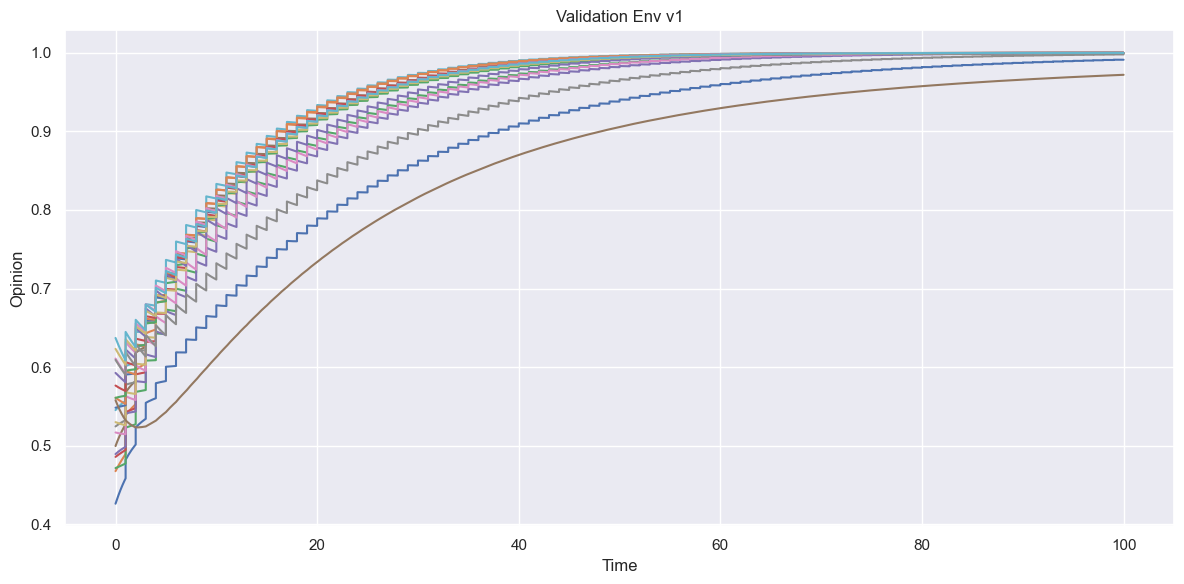

Total discounted reward: -9.3537

--- Running simulation for validation environment version 2 ---
Policy run terminated after 100 steps. Done=False, Truncated=True


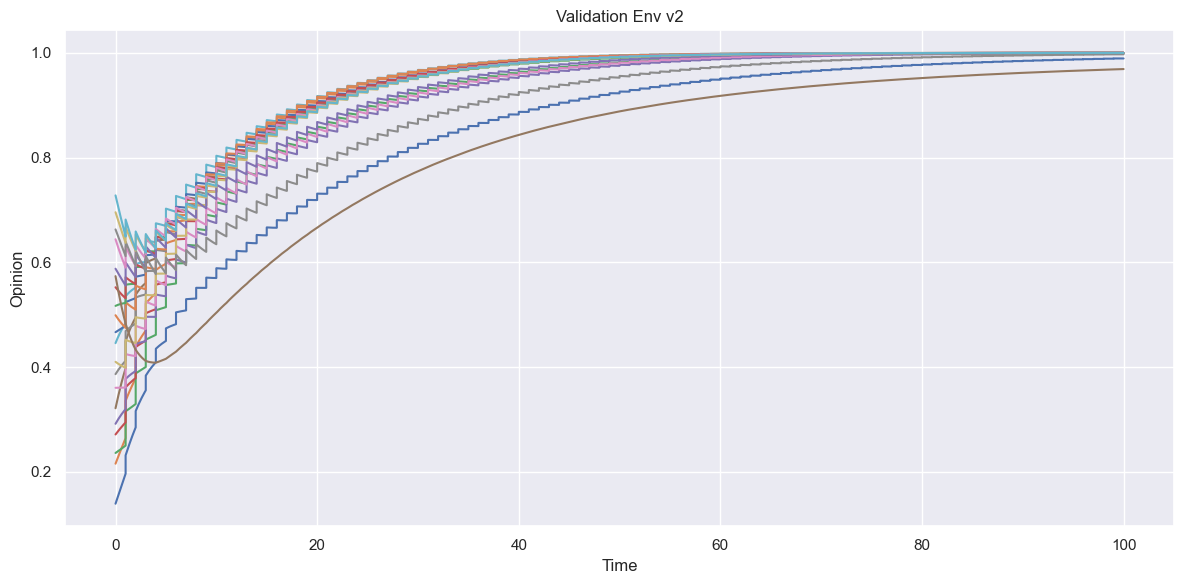

Total discounted reward: -10.8123
   version  discounted_reward
0        0         -13.283780
1        1          -9.353676
2        2         -10.812345


In [36]:


factory = EnvironmentFactory()
num_steps = factory.get_validation_env(0).max_steps
nx = 2
available_budget = 2
gamma = 0.99

results = []

for version in range(len(factory.validation_versions)):
    print(f"\n--- Running simulation for validation environment version {version} ---")
    
    env = factory.get_validation_env(version=version)

    # Define control policy (uniform in this example)
    policy_uniform = np.full(env.num_agents, available_budget / env.num_agents)
    policy_broadcast = generate_control_from_vector(env, nx, policy_uniform)

    # Run policy (returns intermediate states too)
    opinions_over_time, time_points, rewards, actions, all_intermediate_states = run_policy(
        env, policy_broadcast, nx=nx, max_steps=num_steps
    )

    # Flatten the fine-grained intermediate states for plotting
    flat_states, flat_times = flatten_intermediate_states_np(
        all_intermediate_states, t_campaign=env.t_campaign, t_s=env.t_s
    )

    # Plot the high-resolution opinion trajectories
    plot_opinions_over_time(flat_states, time_points=flat_times, title=f"Validation Env v{version}")

    # Compute total discounted reward
    total_value = sum((gamma**i) * r for i, r in enumerate(rewards))
    print(f"Total discounted reward: {total_value:.4f}")
    
    results.append({"version": version, "discounted_reward": total_value})
    
df_results = pd.DataFrame(results)
print(df_results)

-13.757306401291068


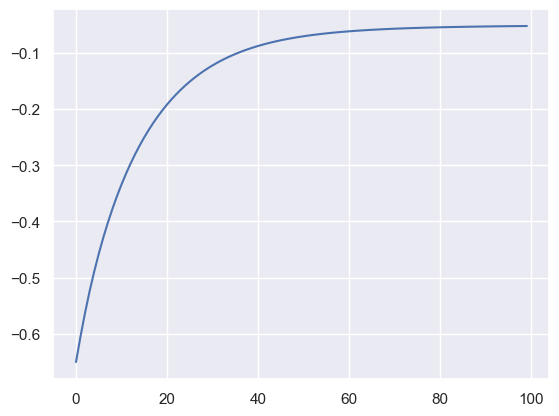

In [37]:
# plot rewards with seaborn

sns.lineplot(x=np.arange(len(rewards)), y=rewards)
print(sum(rewards))


--- Running centrality policy for validation environment version 0 ---
Centrality-based policy finished after 99 steps. Done=False, Truncated=True


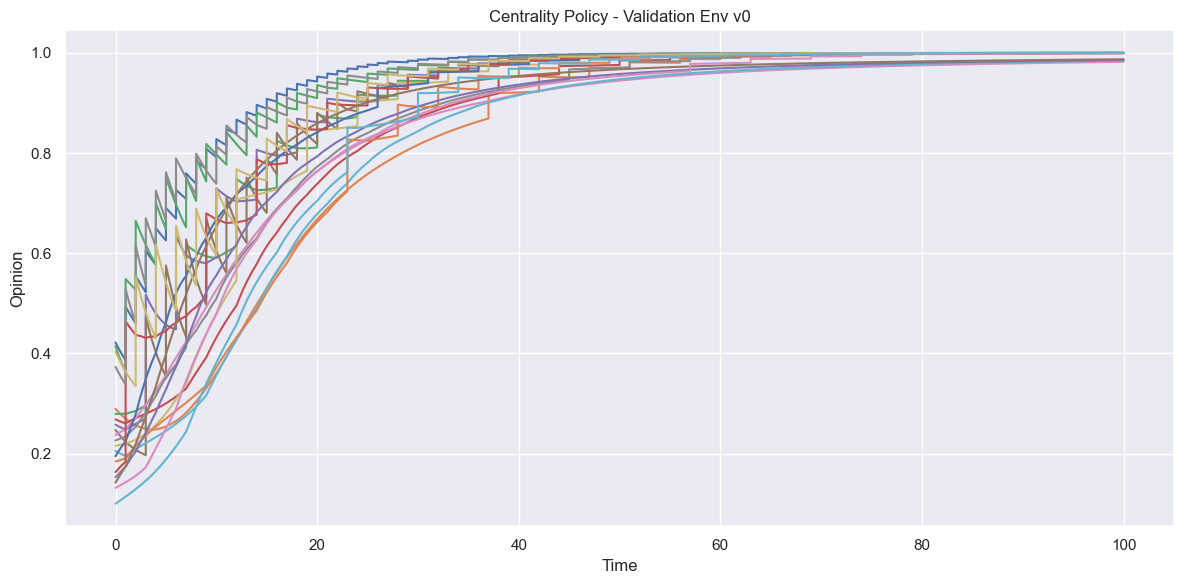

Total discounted reward: -13.9011

--- Running centrality policy for validation environment version 1 ---
Centrality-based policy finished after 99 steps. Done=False, Truncated=True


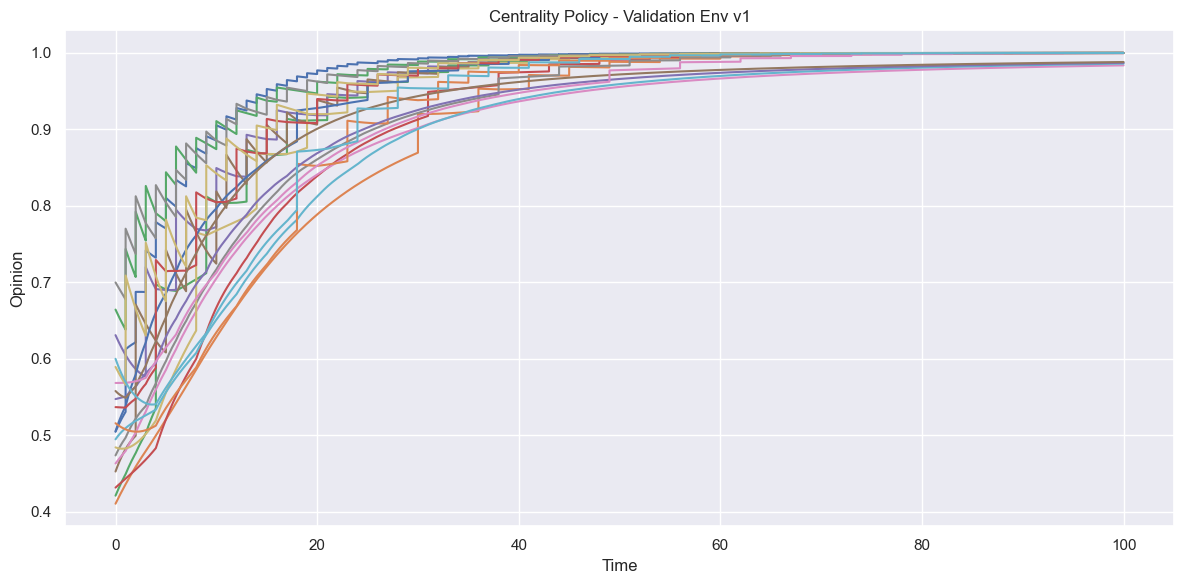

Total discounted reward: -9.5313

--- Running centrality policy for validation environment version 2 ---
Centrality-based policy finished after 99 steps. Done=False, Truncated=True


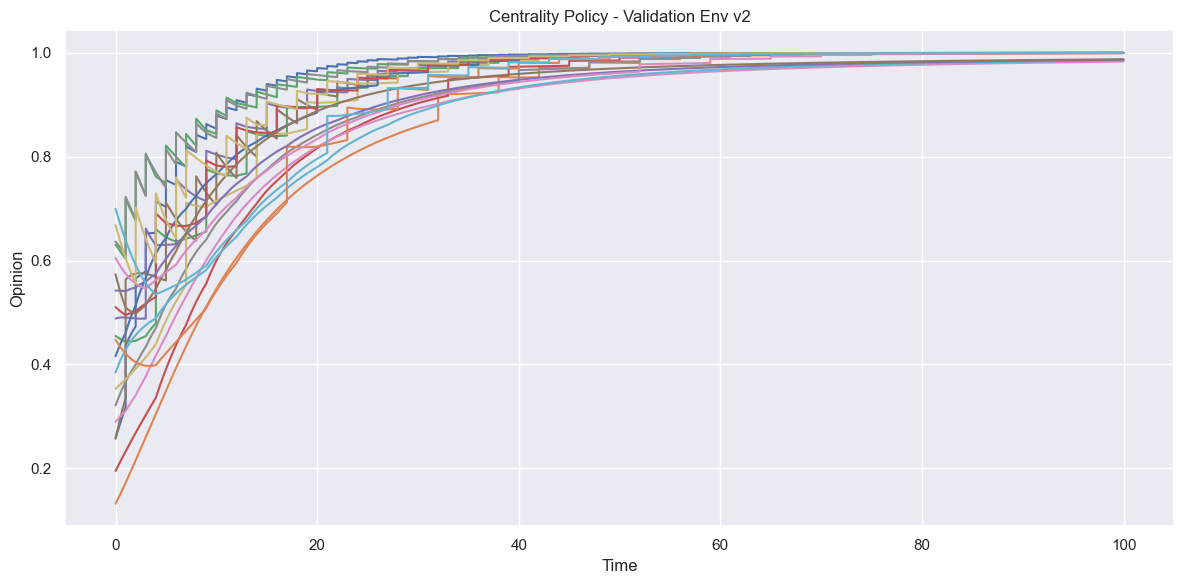

Total discounted reward: -10.6344
   version  discounted_reward
0        0         -13.901059
1        1          -9.531257
2        2         -10.634367


In [38]:
# --- Parameters ---
num_steps = 100
gamma = 0.99
available_budget = 2
nx = 2  # required for control vector construction

factory = EnvironmentFactory()
results = []

env_versions = factory.validation_versions
# env_versions = [0]

for version in range(len(env_versions)):
    print(f"\n--- Running centrality policy for validation environment version {version} ---")
    
    env = factory.get_validation_env(version=version)

    # --- Run centrality-based policy ---
    opinions_over_time, time_points, rewards, actions, intermediary_states = run_centrality_policy(
        env,
        available_budget=available_budget,
        max_steps=num_steps
    )

    # --- Flatten intermediate states for plotting ---
    flat_states, flat_times = flatten_intermediate_states_np(intermediary_states, env.t_campaign, env.t_s)

    # --- Plot ---
    plot_opinions_over_time(flat_states, flat_times, title=f"Centrality Policy - Validation Env v{version}")

    # --- Discounted reward ---
    total_value = sum((gamma ** i) * r for i, r in enumerate(rewards))
    print(f"Total discounted reward: {total_value:.4f}")
    results.append({"version": version, "discounted_reward": total_value})

# --- Print summary table ---
df_results = pd.DataFrame(results)
print(df_results)

In [39]:
print("Desired opinion:", env.desired_opinion)
print("Desired opinion shape:", np.shape(env.desired_opinion))

Desired opinion: 1.0
Desired opinion shape: ()


In [40]:
len(opinions_over_time)

101

In [41]:
len(time_points)


101

In [42]:
sum(rewards)

-13.452809035660726

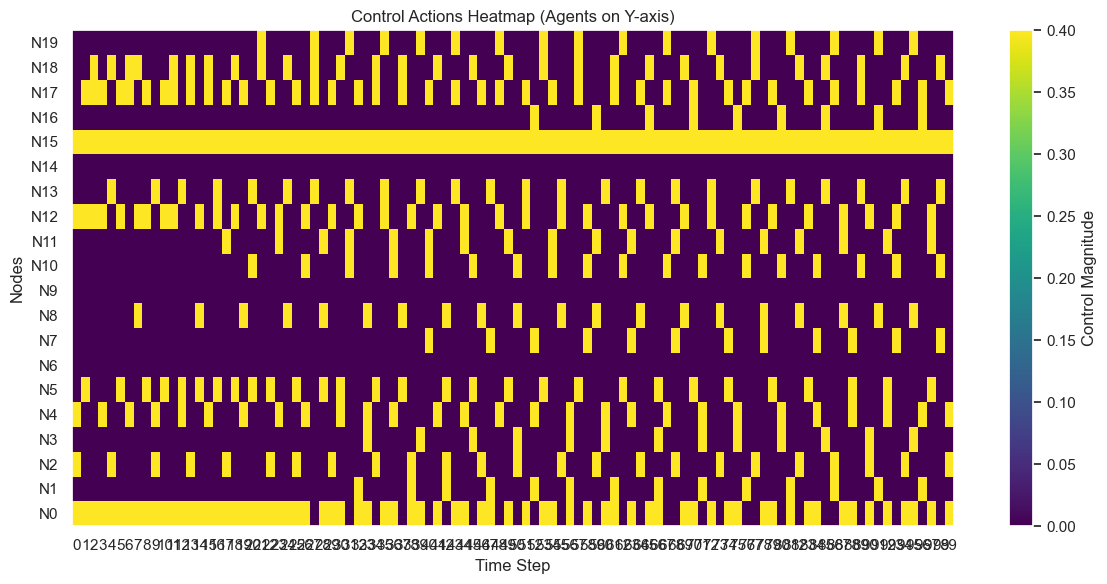

In [43]:
plot_action_heatmap(actions)

In [44]:
# Not feasable with lots of nodes

# env = build_environment()

# # Adjusted parameters
# step_duration = env.tau
# max_total_budget = 2
# action_levels = [0, 0.4]

# V = value_iteration(env, 
#                     action_levels=action_levels,
#                     nx=nx, 
#                     gamma=gamma,  
#                     step_duration=step_duration, 
#                     max_total_budget=max_total_budget)
# policy = extract_policy(
#     env, 
#     V, 
#     action_levels=action_levels, 
#     nx=nx, gamma=gamma, 
#     step_duration=step_duration, 
#     max_total_budget=max_total_budget
# )

In [45]:
# for node_index in range(env.num_agents):
#     visualize_policy_from_env(policy, env, nx=nx, node_index=node_index)

In [46]:
# env = build_environment()
# num_steps = 30

# opinions_over_time, time_points, rewards = run_policy(env, policy, nx=nx, step_duration=env.tau, max_steps=num_steps)
# plot_opinions_over_time(opinions_over_time)
# # sum(rewards)

# total_value = 0
# for i, r in enumerate(rewards):
#     total_value = total_value + (gamma**i) * r
    
# total_value

In [47]:
# env.opinions

In [48]:
# rewards

### DQN: 
Distributes budget beta_k (beta can be selected from discrete interval) across all nodes using W*
beta_k to be chosen constant

###  NAHS 
Distributes total budget B across M campaigns
At each campaign distributes the budget beta_k across all nodes using W_k
distribute the same beta_k as in the dqn experiment, and track